<a href="https://colab.research.google.com/github/SarraLKSC/Salamander_Individual_Identification/blob/main/Notebooks/Thesis_rigid_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import dependencies

In [1]:
!pip3 install pillow-heif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.7 MB/s eta 0:00:00


In [2]:
import os
import cv2
import math
import random
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.cluster import KMeans
from skimage.transform import rotate
from pillow_heif import register_heif_opener
from sklearn.metrics import silhouette_score
from skimage.measure import label, regionprops, regionprops_table

# 1. Load data

In [3]:
register_heif_opener()
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images =["/content/drive/MyDrive/upright_salamandre_data/train/images/"+ doc for doc in os.listdir("/content/drive/MyDrive/upright_salamandre_data/train/images")]
v_images= ["/content/drive/MyDrive/upright_salamandre_data/val/images/"+ doc for doc in os.listdir("/content/drive/MyDrive/upright_salamandre_data/val/images")]

masks =["/content/drive/MyDrive/upright_salamandre_data/train/masks/"+doc for doc in os.listdir("/content/drive/MyDrive/upright_salamandre_data/train/masks")]
v_masks=["/content/drive/MyDrive/upright_salamandre_data/val/masks/"+doc for doc in os.listdir("/content/drive/MyDrive/upright_salamandre_data/val/masks")]

In [5]:
img_root="/content/drive/MyDrive//upright_salamandre_data/train/images"
msk_root="/content/drive/MyDrive//upright_salamandre_data/train/masks"

vimg_root="/content/drive/MyDrive//upright_salamandre_data/val/images"
vmsk_root="/content/drive/MyDrive//upright_salamandre_data/val/masks"

In [6]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [7]:
#### FUNCTION CELL ####

def non_stretching_resize(img,cmap,desired_size=256):

    old_size= img.size
    ratio= float(desired_size)/max(old_size)
    new_size =tuple([int(x * ratio) for x in old_size])
    #print(new_size)
    im = img.resize(new_size,resample= Image.ANTIALIAS)

    new_im = Image.new(cmap, (desired_size, desired_size))
    new_im.paste(im, ((desired_size - new_size[0]) // 2,
                          (desired_size - new_size[1]) // 2))

    img_array=np.asarray(new_im)/255.
    return new_im

def segment(img,msk):
  image=img.copy()
  image[msk<0.3]=0
  return image

In [8]:
def load_batch(batch=0):
  msk_samples=[]
  img_samples=[]
  sgmnt_samples=[]

  start=50*batch
  for i in range(start,start+50):
    if i>len(masks):
      return msk_samples,img_samples,sgmnt_samples
    msk_= np.asarray(Image.open(os.path.join(msk_root,masks[i])).convert('L'))
    msk_samples.append(msk_)
    img_= np.asarray(Image.open(os.path.join(img_root,images[i])))
    img_samples.append(img_)
    if(msk_.shape != img_.shape[:-1]):
      print(msk_.shape,img_.shape)
      plt.subplot(1,2,1)
      plt.imshow(img_)
      plt.subplot(1,2,2)
      plt.imshow(msk_,cmap="gray")
      plt.show()
    sgmnt_samples.append(segment(img_,msk_))
    print("\r"+str(i)+"/"+str(len(images)),end="")

  return msk_samples,img_samples,sgmnt_samples

In [9]:
msk_samples=[]
img_samples=[]
sgmnt_samples=[]

for i in range(50,100):
  msk_= np.asarray(Image.open(os.path.join(msk_root,masks[i])).convert('L'))
  msk_samples.append(msk_)
  img_= np.asarray(Image.open(os.path.join(img_root,images[i])))
  img_samples.append(img_)
  sgmnt_samples.append(segment(img_,msk_))
  print("\r"+str(i)+"/"+str(len(images)),end="")

#for i in range(len(v_masks)):
#  msk_= np.asarray(Image.open(os.path.join(vmsk_root,v_masks[i])).convert('L'))
#  msk_samples.append(msk_)
#  img_= np.asarray(Image.open(os.path.join(vimg_root,v_images[i])))
  #img_samples.append(img_)
#  sgmnt_samples.append(segment(img_,msk_))

#shape_samples=[s_mask.shape for s_mask in msk_samples]

99/1005

# 2. Affine transforms

In [10]:
#### FUNCTION CELL ####

def cropping_bounds(img):
  """
    get coordinates of bounding box around the salamander mask
    img: binary mask of salamander body
    return: quadruplet of bbox coordinates
  """
  regions = regionprops(img)
  props=regions[0]
  minr, minc, maxr, maxc = props.bbox
  """
  if minr>10:
    minr=minr-10
  if minc>10:
    minc=minc-10
  if maxc<250:
    maxc=maxc+10
  if maxr<250:
    maxr=maxr+10
    """
  return minr,minc,maxc,maxr

def crop_image(img):
  """
    crop the mask based on the anontated salamander body bbox
    img: binary mask of salamander body
    return: cropped mask around the animal body (rectangle)

  """
  minr,minc,maxc,maxr=cropping_bounds(img)
  cropped=img[minr:maxr,minc:maxc]
  return cropped

def crop_image_s_mask(img,msk):
  """
    crop the image based on the annotated mask salamander body bbox
    img: image sample
    msk: correcpsonding binary mask
    return: cropped imaged around animal body (rectangle)

  """
  minr,minc,maxc,maxr=cropping_bounds(msk)
  cropped_img=img[minr:maxr,minc:maxc]
  return cropped_img

def zoom_bounds(img,msk,plot=True):
  """
    zoom on the image based on the annotated mask salamander body bbox
    img: image sample
    msk: correcpsonding binary mask
    return: cropped imaged around animal body (rectangle)
  """
  SIZE=256
  minr,minc,maxc,maxr=cropping_bounds(msk)
  newminr, newminc, newmaxc,newmaxr=minr,minc,maxc,maxr
  h=maxr-minr
  w=maxc-minc

  bound=SIZE
  if img.shape==(SIZE,SIZE):
    bound=max(h,w)
  if h<=SIZE:

    halfr= minr + h//2
    newminr=max( halfr - bound/2,0)
    newmaxr= halfr + bound/2
  else:
    bound=h
    newminr,newmaxr = minr, maxr


  if w<=h:
    halfc= minc+ w//2
    newminc = max(halfc - bound/2,0)
    newmaxc = min(halfc + bound/2,img.shape[1])


  else:
    newminc, newmaxc= minc,maxc

  cropped_img=img[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]
  if plot:
    plt.imshow(cropped_img)
    plt.show()

  return newminr, newminc, newmaxc,newmaxr



In [11]:
#### FUNCTION CELL ####

def fitted_line(msk_sample,plot=True,scatter=False,ax_rotation=False):
  """
      computed fitted line that goes through salamander body mask
      msk: the binary mask of the salamander body
      plot: boolean, true if we want to splot the result
      return: the coordinates of line start and line end
  """
  contours, hierarchy = cv2.findContours(msk_sample, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  rows, cols = msk_sample.shape

  # Calculate endpoints of the line
  vx, vy, x, y = cv2.fitLine(contours[0], cv2.DIST_L2, 0, 0.01, 0.01)

  starty = 0

  if vy!=0:
    startx = int((starty - y) * (vx / vy) + x)
    bottomy = rows - 1
    bottomx = int((bottomy - y) * (vx / vy) + x)
  else:
    startx= bottomx =x
    bottomy = rows - 1

  # Check if the line goes out of bounds
  if startx < 0:
      startx, starty = 0, int(y - (x / vx) * vy)
  elif startx >= cols:
      startx, starty = cols - 1, int(y + ((cols - 1 - x) / vx) * vy)
  if bottomx < 0:
      bottomx, bottomy = 0, int(y - (x / vx) * vy)
  elif bottomx >= cols:
      bottomx, bottomy = cols - 1, int(y + ((cols - 1 - x) / vx) * vy)


  if plot:
  # Plot the line
    fig, ax = plt.subplots()
    ax.imshow(msk_sample, cmap='gray')
    ax.plot([startx, bottomx], [starty, bottomy], color='red', linewidth=2)
    if ax_rotation:
        midx= startx + (bottomx-startx)//2
        ax.plot( [midx,midx] , [starty,bottomy],color="blue",linewidth=2)
    if scatter:
      ax.scatter([startx],[starty],color="pink",linewidth=3)
      ax.scatter([bottomx],[bottomy],color="orange",linewidth=3)
    plt.show()
  return (startx,bottomx),(starty,bottomy)

In [12]:
#### FUNCTION CELL ####

def rotate_img(msk,angle=30,plot=True):

  # Get image size and center
  h, w = msk.shape[:2]
  cx, cy = w // 2, h // 2

  # Calculate rotation matrix
  M = cv2.getRotationMatrix2D((cx, cy), -int(angle), 1.0)

  # Apply rotation to image
  rotated = cv2.warpAffine(msk, M, (w, h), flags=cv2.INTER_LINEAR)
  if plot:
    # Display result
    fig=plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.imshow( rotated,cmap="gray")
    plt.title("Rotated Image")
    plt.subplot(1,2,2)
    plt.imshow(msk,cmap="gray")
    plt.title("original image")
    plt.show()
  return rotated

def rotation_angle(msk):

  #compute angle

  (startx,bottomx),(starty,bottomy)= fitted_line(msk,plot=False)
  # Calculate the angle of the fitted line
  dy = bottomy - starty
  dx = bottomx - startx
  angle = np.arctan2(dy, dx) * 180 / np.pi

  # Calculate the angle difference between the fitted line and vertical axis
  angle_diff = angle - 90

  return -angle_diff

def apply_rotate_img(msk,replicate=False):

  alpha=rotation_angle(msk)
  if replicate:
    return alpha
  else:
    return(rotate_img(msk,alpha,False))

def replicate_rotate(img,msk):

  alpha=apply_rotate_img(msk,True)

  return(rotate_img(img,alpha,False))

In [13]:
#### FUNCTION CELL ####

# Translation and centering

def center_shift(msk):

  start,end=fitted_line(msk,False)

  # Calculate the center of the bounding box
  bbox_center = np.array([start[0], (end[1]//2)])

  h, w = msk.shape[:2]

  # Calculate the center of the image
  mskcenter = np.array([w/2, h/2])

  # Calculate the shift needed to move the bounding box to the center of the image
  shift = mskcenter - bbox_center
  # Define the translation matrix
  translation_matrix = np.array([[1, 0, shift[0]], [0, 1, shift[1]]], dtype=np.float32)

  return translation_matrix


def center_mask(msk,replicate=False):

  translation_matrix=center_shift(msk)
  h, w = msk.shape[:2]
  msk_shifted = cv2.warpAffine(msk, translation_matrix, (w, h))
  if replicate:
    return translation_matrix
  else:
    return msk_shifted

def replicate_centering(img,msk):

  translation_matrix=center_mask(msk,True)
  h, w = img.shape[:2]
  img_shifted = cv2.warpAffine(img, translation_matrix, (w, h))
  return img_shifted


In [14]:
#### FUNCTION CELL ####

def run_affine_transform(msk,img=None,replicate=False):
  """
    applied affine transformation to match desired template
    msk: binary mask to transform
    img: corresponding segmented image, used if replicate= True
    replicate: boolean, if false applies transformation to msk, if true maps msk transformation to img
    return: transformed mask (resize, rotate, scale, translate)
  """

  #resize to 256,256
  to_resize = Image.fromarray((msk * 255).astype(np.uint8))
  sample= np.array(non_stretching_resize(to_resize,"L"))

  # rotate image
  start,end=fitted_line(sample,False)
  rotated_img=apply_rotate_img(sample)

  # zoom in and crop
  newminr, newminc, newmaxc,newmaxr=zoom_bounds(rotated_img,rotated_img,False)
  cropped_img=rotated_img[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]

  # translate
  img_shifted = center_mask(cropped_img)

  if replicate:
    #print("replicate on sgmnt")
    to_resize2 = Image.fromarray((img * 1).astype(np.uint8))
    segm= np.array(non_stretching_resize(to_resize2,"RGB"))
    rotated_sgm=replicate_rotate(segm,sample)
    cropped_sgm=rotated_sgm[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]
    sgm_shifted = replicate_centering(cropped_sgm,cropped_img)

    return img_shifted,sgm_shifted
  else:
    return img_shifted




In [15]:
#### FUNCTION CELL ####


def curved_salam(msk,return_angle=False):
  """
    returns if the salamander if curved or not
    msk: salamander mask
    return: boolean that is true
  """
  THRESHOLD=165
  h,c,t= approx_polygone_points(msk)
  x1, y1 = h[0][0], h[0][1]
  x2, y2 = cx, cy= c
  upper_body_vec = np.array([h[0][0] - x2, h[0][1] - y2])
  lower_body_vec = np.array([t[0][0] - x2, t[0][1] - y2])
  angle = np.degrees(np.arctan2(np.linalg.det([upper_body_vec, lower_body_vec]), np.dot(upper_body_vec, lower_body_vec)))
  if return_angle:
    return abs(angle)<THRESHOLD,angle
  else:
    return abs(angle)<THRESHOLD

def approx_polygone_points(msk,plot=False):

  contours, _ = cv2.findContours(msk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt=np.concatenate(contours)
  perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour with a polygonal curve
  approx_curve = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    # Centroid
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])
  centroid = (cx,cy)

  img = cv2.cvtColor(msk, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
  approx_curve = np.append(approx_curve, [approx_curve[0]], axis=0)

  x = approx_curve[:, 0, 0]
  y = approx_curve[:, 0, 1]
  head_point=min(approx_curve,key=lambda x: x[0][1])
  tail_point=max(approx_curve,key=lambda x: x[0][1])
  if plot:
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    img = cv2.cvtColor(msk, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
    axs[0].imshow(img)
    axs[0].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
    axs[0].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
    axs[0].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")

    axs[0].plot(x, y, '-r', linewidth=2,zorder=2)
    axs[0].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
    axs[0].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
    axs[1].imshow(msk,cmap="gray")
    upper_body_vec = np.array([head_point[0][0] - cx, head_point[0][1] - cy])
    lower_body_vec = np.array([tail_point[0][0] - cx, tail_point[0][1] - cy])
    angle = np.degrees(np.arctan2(np.linalg.det([upper_body_vec, lower_body_vec]), np.dot(upper_body_vec, lower_body_vec)))
    print("Angle between upper and lower body lines: {:.2f} degrees".format(abs(angle)))

    plt.show()

  return head_point,centroid,tail_point

def unwrap_curve(msk,sgm,normalized=False,smooth=0):

  #normalize if necessary
  if not(normalized):
    msk,sgm=run_affine_transform(msk,sgm,replicate=True)

  sgm = cv2.copyMakeBorder(sgm, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value = 0)
  msk = cv2.copyMakeBorder(msk, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value = 0)

  #get required points
  head_point,centroid,tail_point = approx_polygone_points(msk)
  x1, y1 = head_point[0][0], head_point[0][1]
  x2, y2 = cx, cy = centroid[0],centroid[1]
 # print("INSIDE UNWARP: centroid={} ; head_point= {} ; tail_point= {} ".format(centroid,head_point,tail_point))
  #computer angle between upper body vect and vertical axis
  angle = np.arctan2(x2 - x1, y2 - y1) * 180 / np.pi

  #split segment int upper and lower based on centroid
  upper_bod=sgm[:cy,:]
  lower_bod=sgm[cy:,:]
  upper_bod_m=msk[:cy,:]
  lower_bod_m=msk[cy:,:]
  #rotate uppder bod
  rotated_upper_bod = rotate(upper_bod,-angle)
  rotated_upper_bod=(rotated_upper_bod*255).astype(np.uint8)
  rotated_upper_bod_m = rotate(upper_bod_m,-angle)
  rotated_upper_bod_m=(rotated_upper_bod_m*255).astype(np.uint8)

  #trnaslate lower bod

  shiftx=cx- head_point[0][0]
  if shiftx>0:
   # print("to the left")
    shiftx=shiftx-smooth
  else:
    shiftx=shiftx+smooth
    #print("to the right")

  M = np.float32([[1,0,-(shiftx)],
                [0,1,0]])
  rows,cols,ch = lower_bod.shape
 # print(shiftx)

  lower_bod=cv2.warpAffine(lower_bod,M,(cols,rows))
  lower_bod_m=cv2.warpAffine(lower_bod_m,M,(cols,rows))

  #concatenate upper and lower
  new_salam_sgm=np.concatenate((rotated_upper_bod,lower_bod),axis=0)
  new_salam_msk=np.concatenate((rotated_upper_bod_m,lower_bod_m),axis=0)

  return(new_salam_sgm,new_salam_msk)


In [16]:

def sheer(msk,sgm,normalized=False,normalize=True):

  # transform if necessary
  if not(normalized):
    msk,sgm=run_affine_transform(msk,sgm,replicate=True)

  # expand black background in case the foreground moves off the borders
  sgm = cv2.copyMakeBorder(sgm, 120, 10, 120, 0, cv2.BORDER_CONSTANT, None, value = 0)
  msk = cv2.copyMakeBorder(msk, 120, 10, 120, 0, cv2.BORDER_CONSTANT, None, value = 0)
  # sheer transform
  M = np.float32([[1,-0.7,0],
                [0,1,0]])
  rows,cols,ch = sgm.shape
  sheer_sgm = cv2.warpAffine(sgm, M,(cols,rows))
  sheer_msk = cv2.warpAffine(msk, M,(cols,rows))

  if normalize:
    sheer_msk,sheer_sgm=run_affine_transform(sheer_msk,sheer_sgm,True)

  return sheer_msk,sheer_sgm

# 3. Vizualization of transformations

<ipython-input-7-8494a5e99628>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = img.resize(new_size,resample= Image.ANTIALIAS)


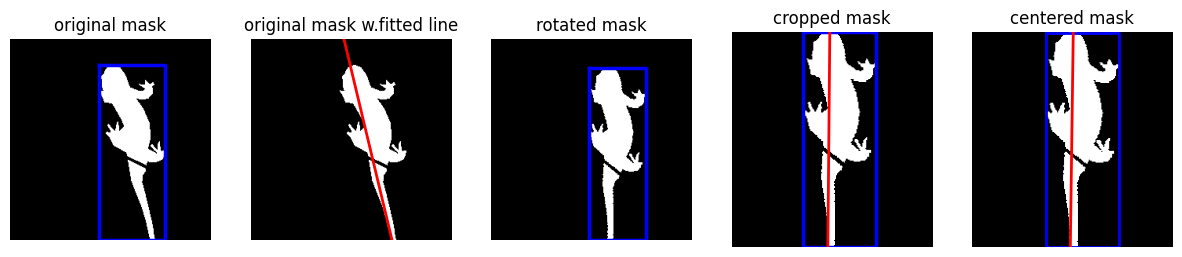

<Figure size 640x480 with 0 Axes>

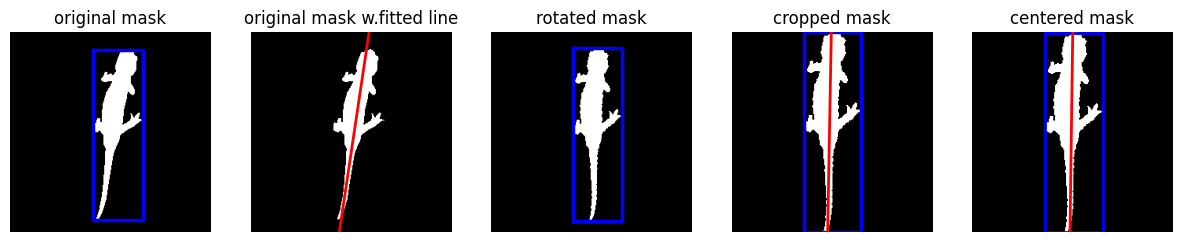

<Figure size 640x480 with 0 Axes>

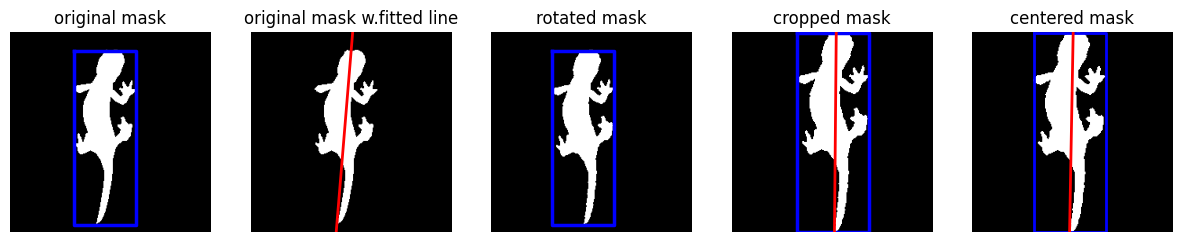

<Figure size 640x480 with 0 Axes>

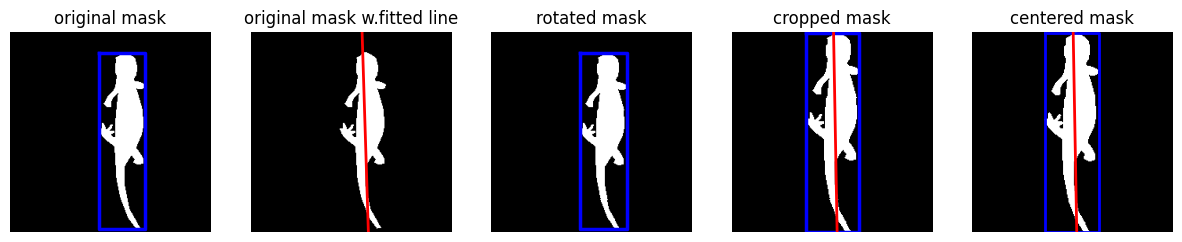

<Figure size 640x480 with 0 Axes>

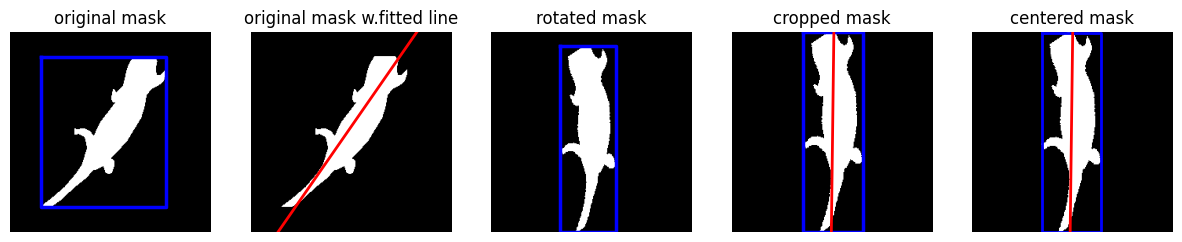

<Figure size 640x480 with 0 Axes>

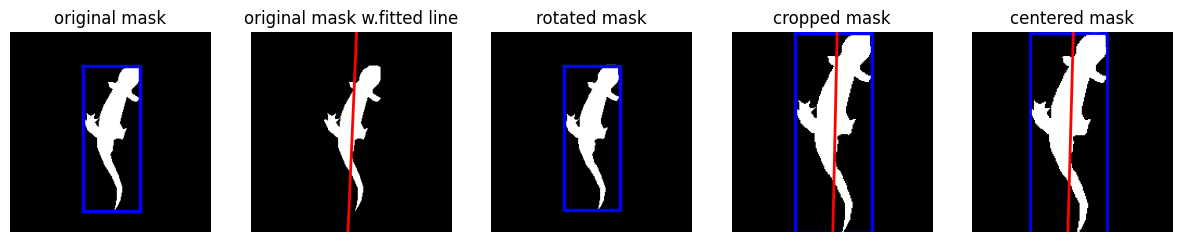

<Figure size 640x480 with 0 Axes>

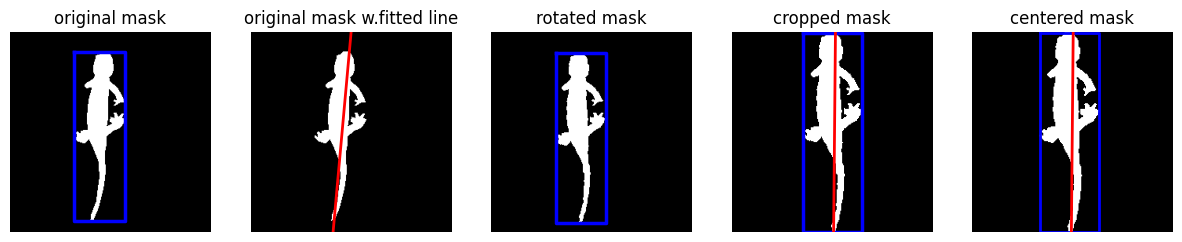

<Figure size 640x480 with 0 Axes>

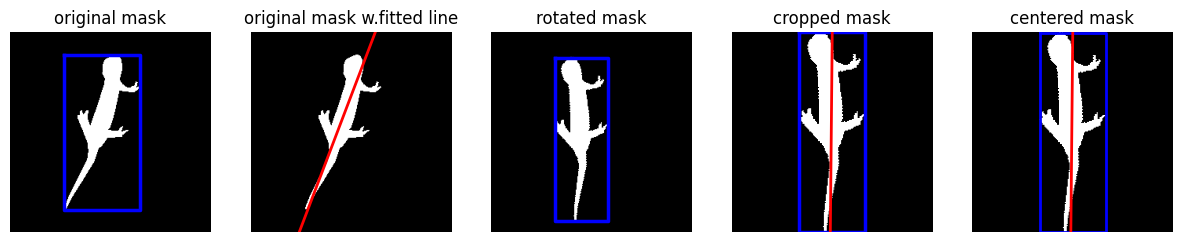

<Figure size 640x480 with 0 Axes>

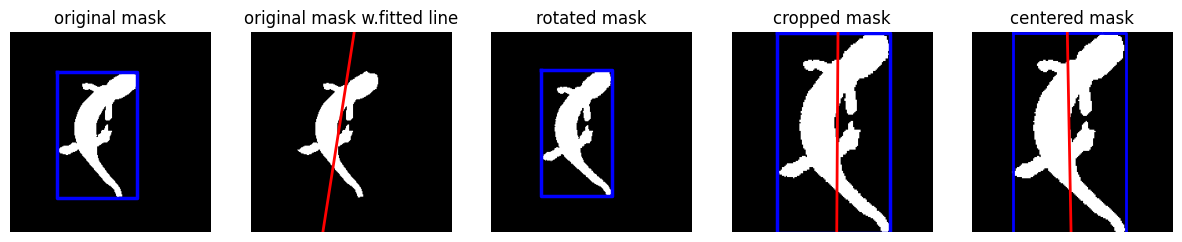

<Figure size 640x480 with 0 Axes>

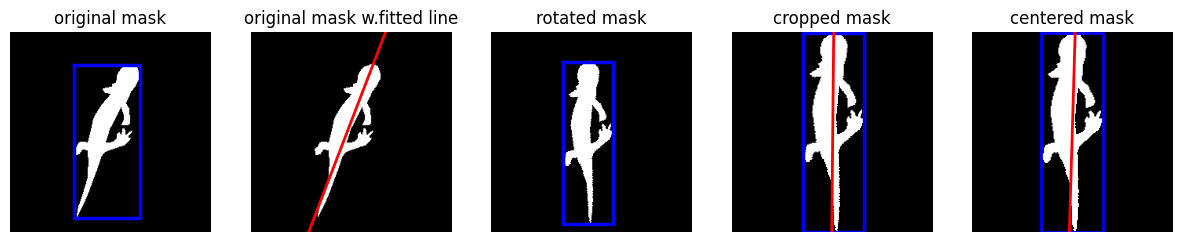

<Figure size 640x480 with 0 Axes>

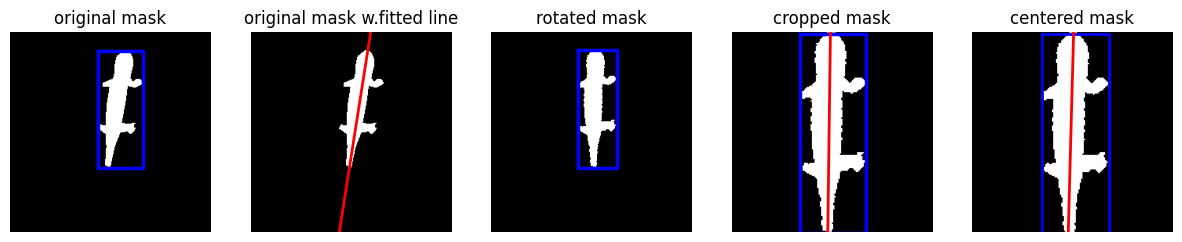

<Figure size 640x480 with 0 Axes>

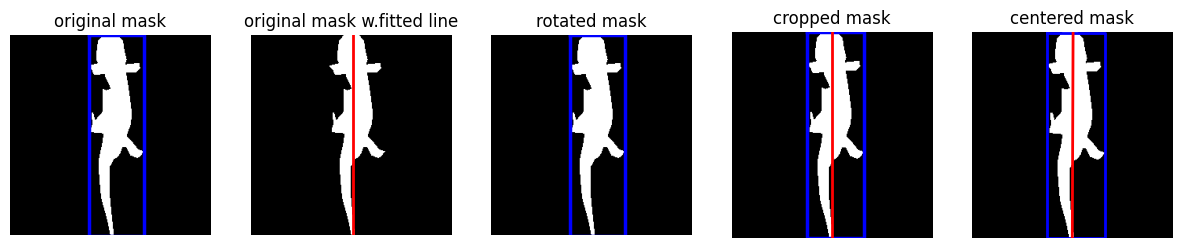

<Figure size 640x480 with 0 Axes>

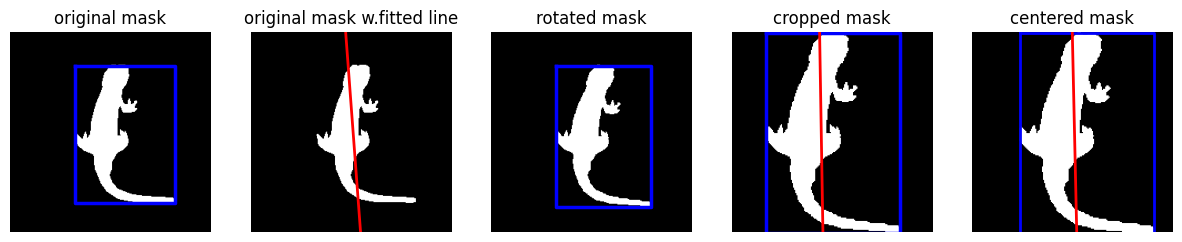

<Figure size 640x480 with 0 Axes>

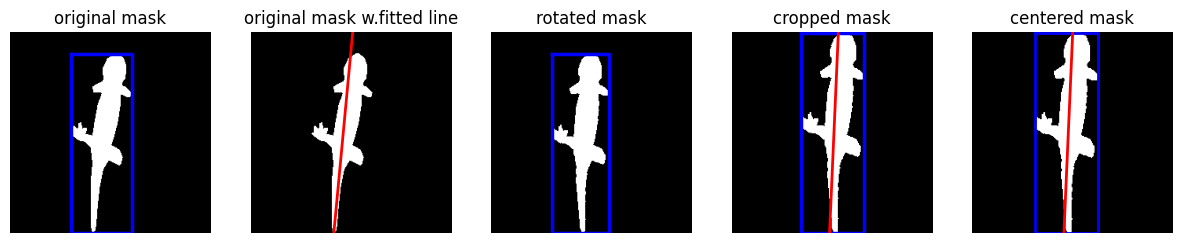

<Figure size 640x480 with 0 Axes>

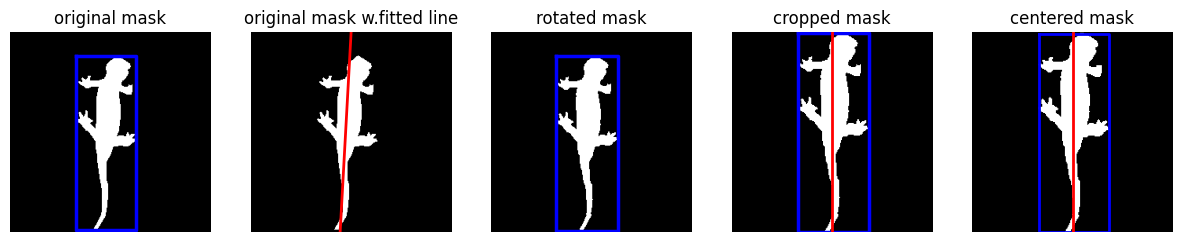

<Figure size 640x480 with 0 Axes>

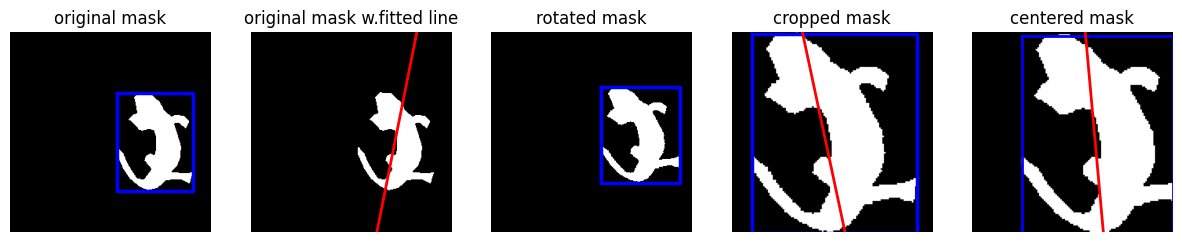

<Figure size 640x480 with 0 Axes>

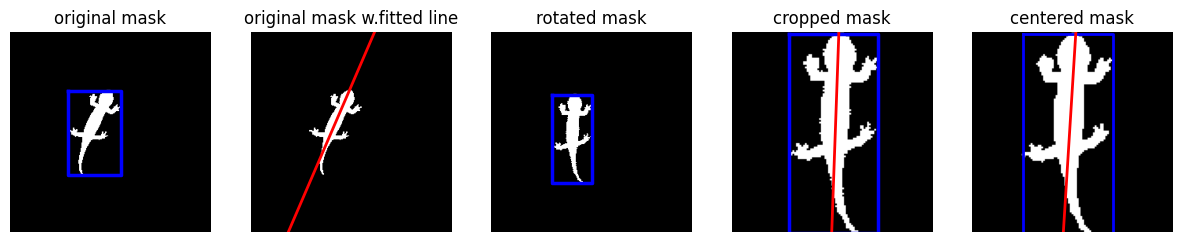

<Figure size 640x480 with 0 Axes>

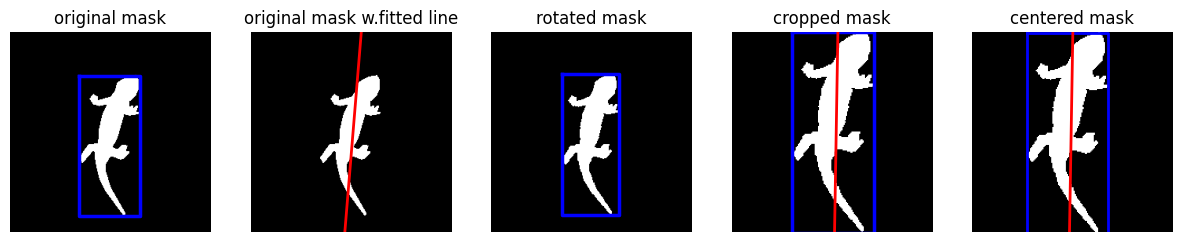

<Figure size 640x480 with 0 Axes>

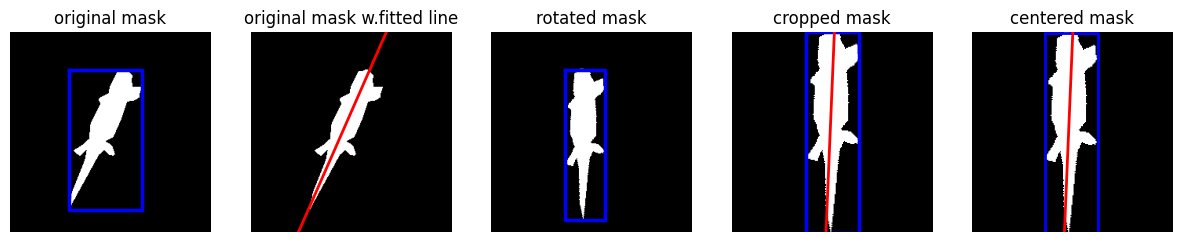

<Figure size 640x480 with 0 Axes>

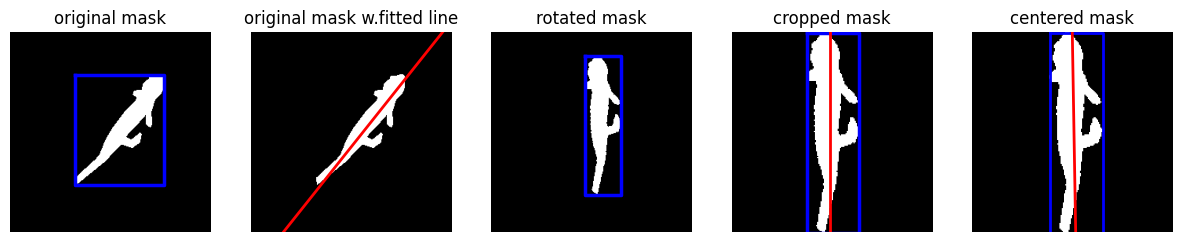

<Figure size 640x480 with 0 Axes>

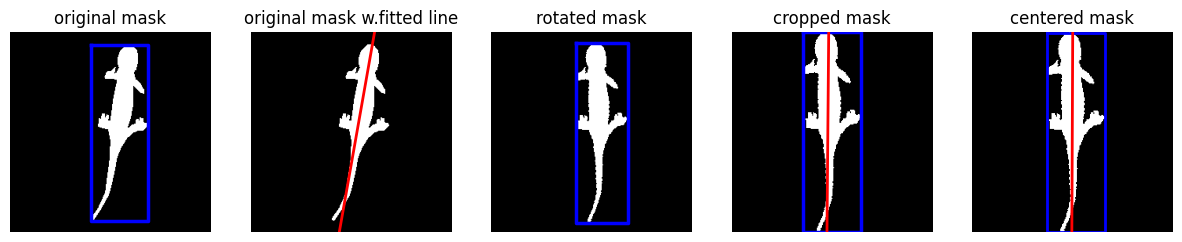

<Figure size 640x480 with 0 Axes>

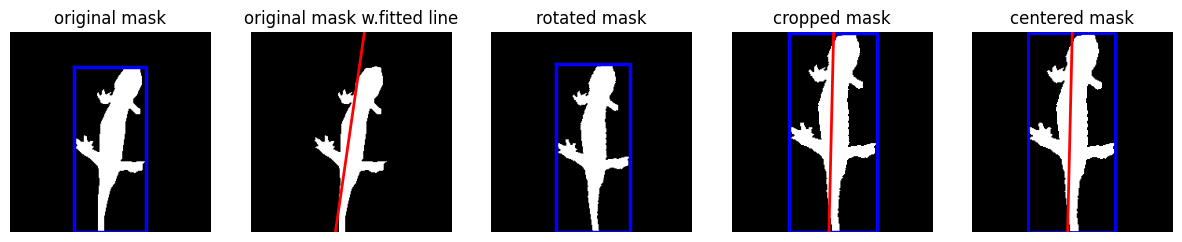

<Figure size 640x480 with 0 Axes>

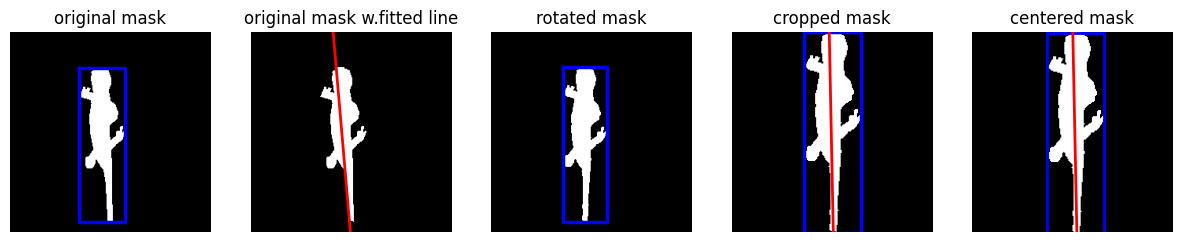

<Figure size 640x480 with 0 Axes>

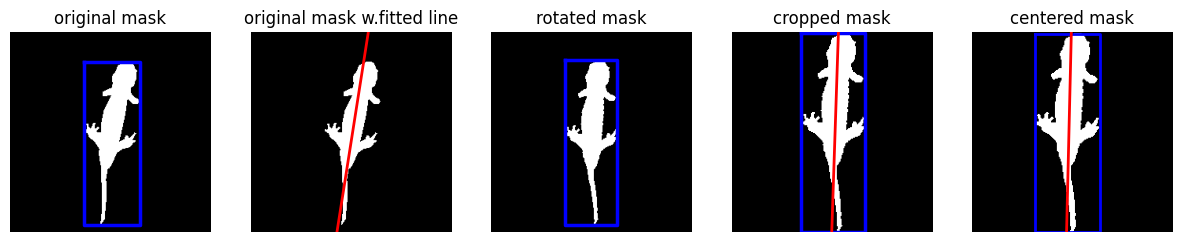

<Figure size 640x480 with 0 Axes>

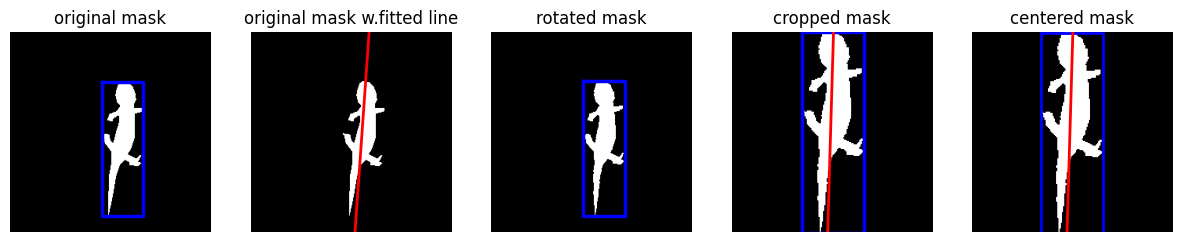

<Figure size 640x480 with 0 Axes>

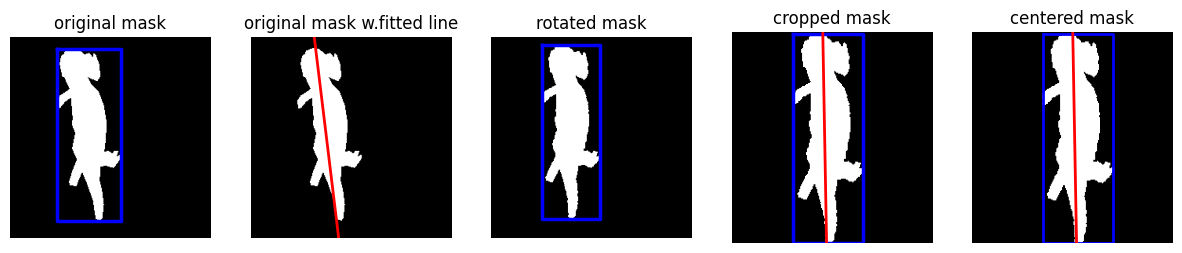

<Figure size 640x480 with 0 Axes>

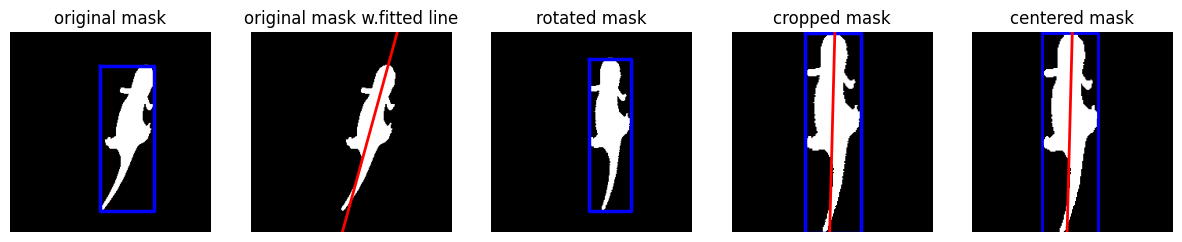

<Figure size 640x480 with 0 Axes>

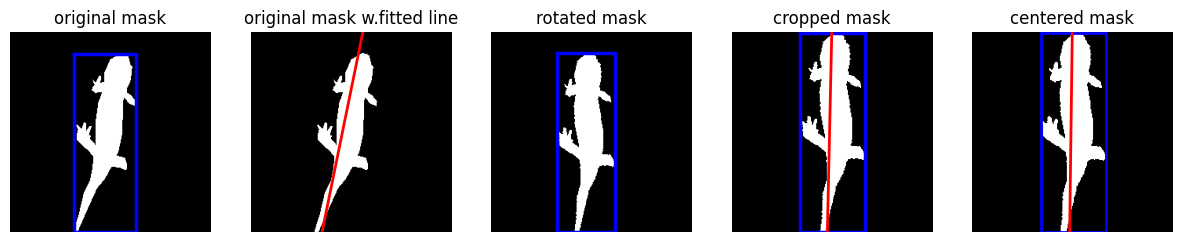

<Figure size 640x480 with 0 Axes>

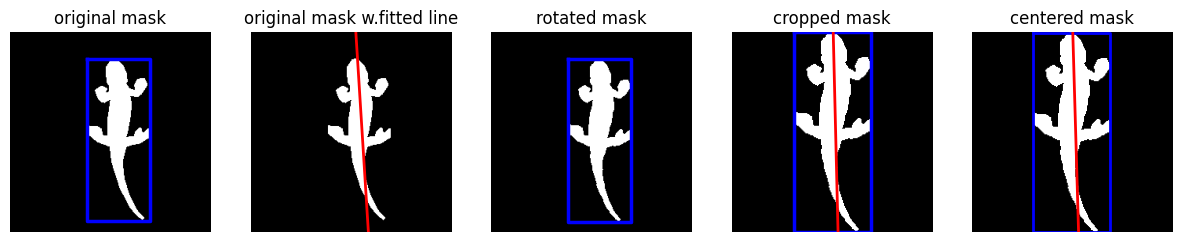

<Figure size 640x480 with 0 Axes>

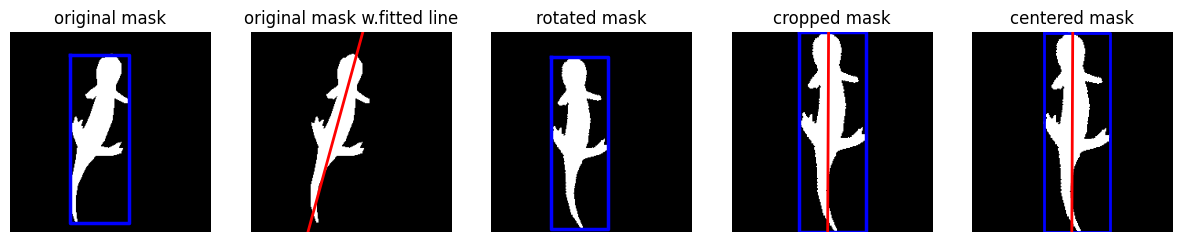

<Figure size 640x480 with 0 Axes>

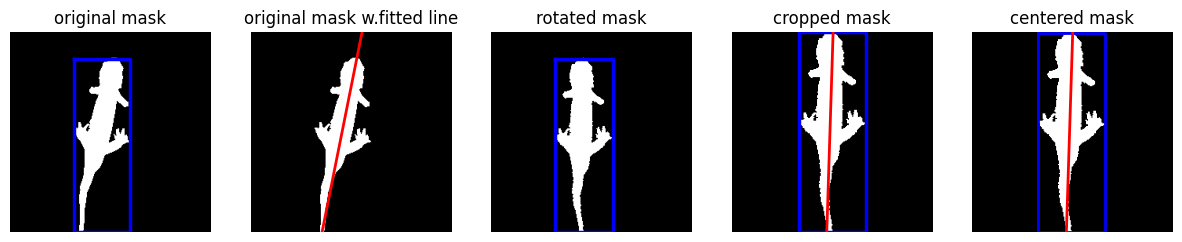

<Figure size 640x480 with 0 Axes>

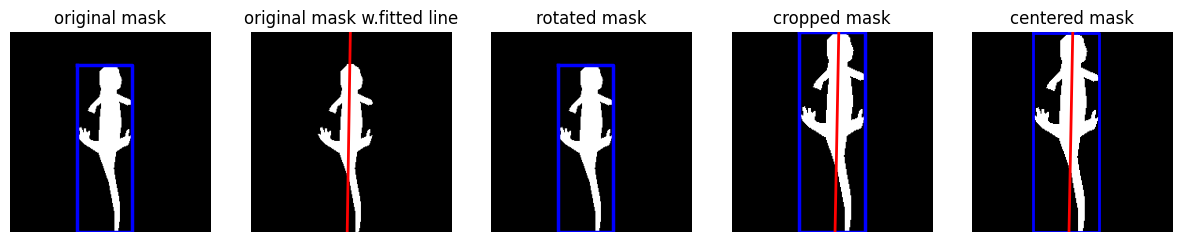

<Figure size 640x480 with 0 Axes>

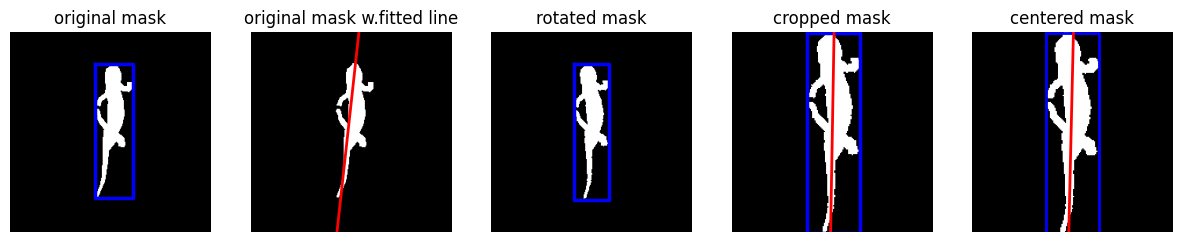

<Figure size 640x480 with 0 Axes>

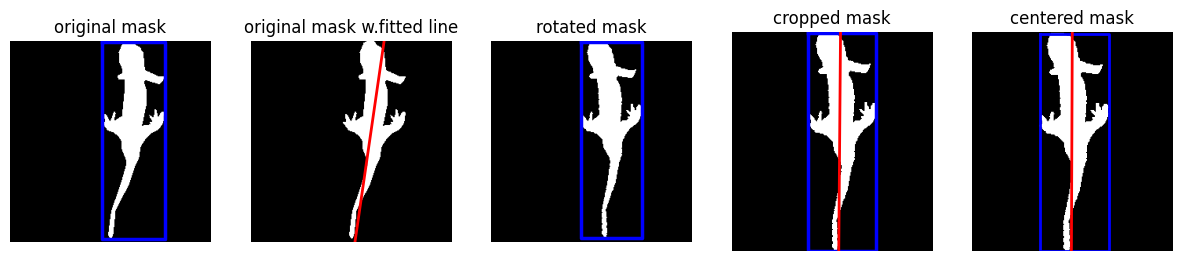

<Figure size 640x480 with 0 Axes>

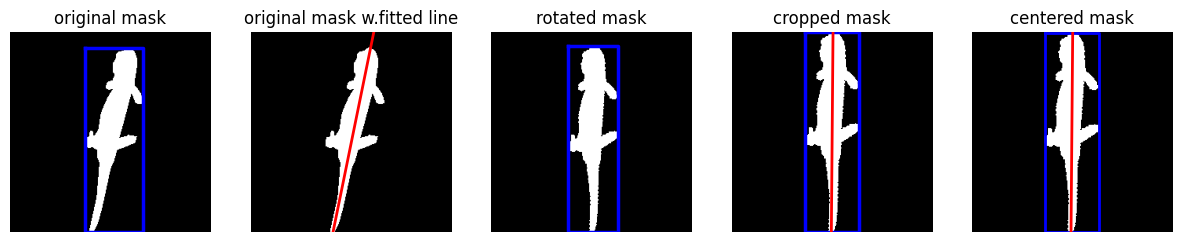

<Figure size 640x480 with 0 Axes>

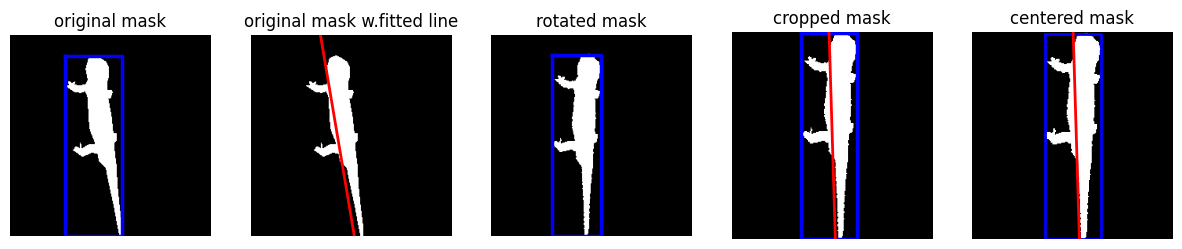

<Figure size 640x480 with 0 Axes>

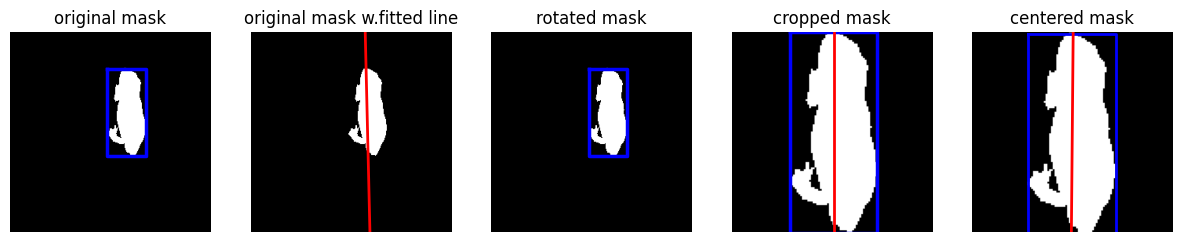

<Figure size 640x480 with 0 Axes>

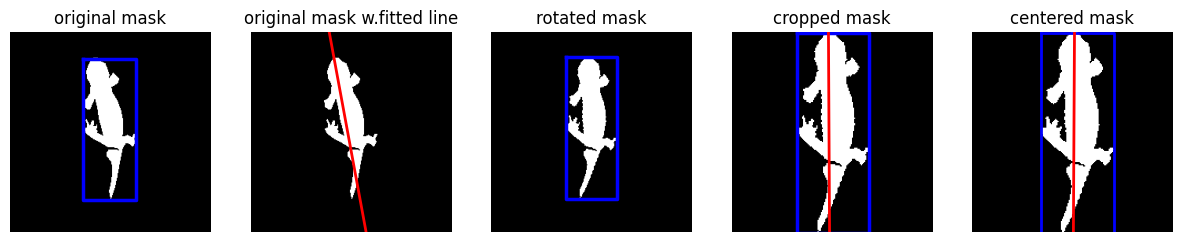

<Figure size 640x480 with 0 Axes>

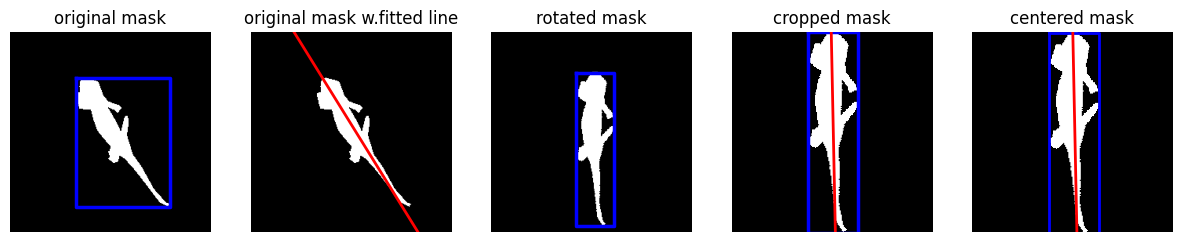

<Figure size 640x480 with 0 Axes>

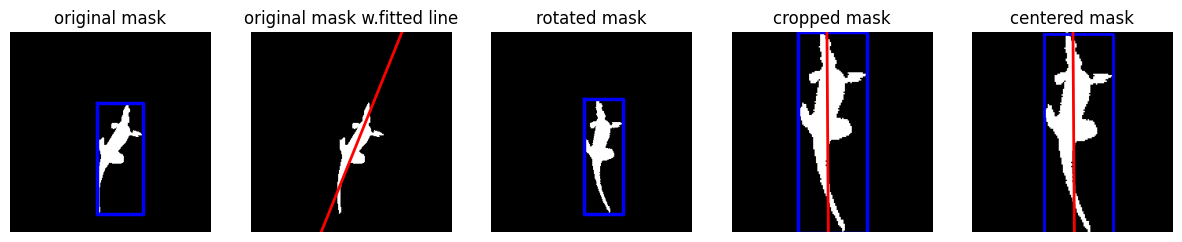

<Figure size 640x480 with 0 Axes>

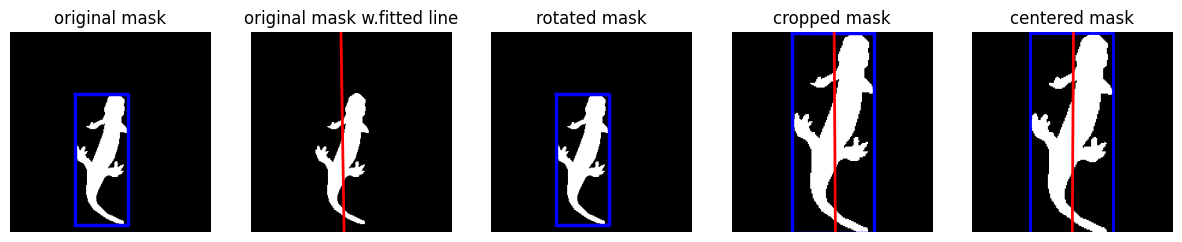

<Figure size 640x480 with 0 Axes>

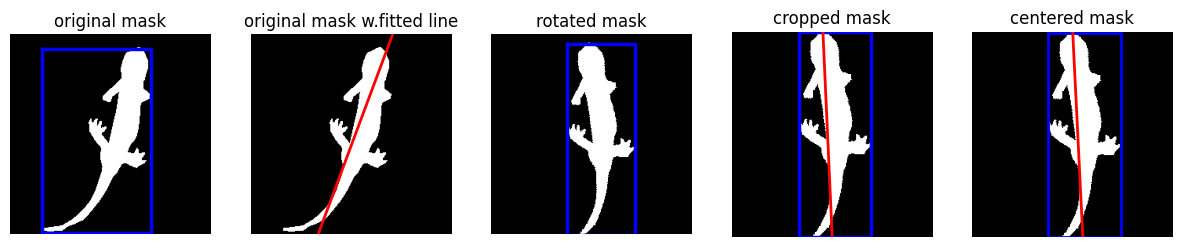

<Figure size 640x480 with 0 Axes>

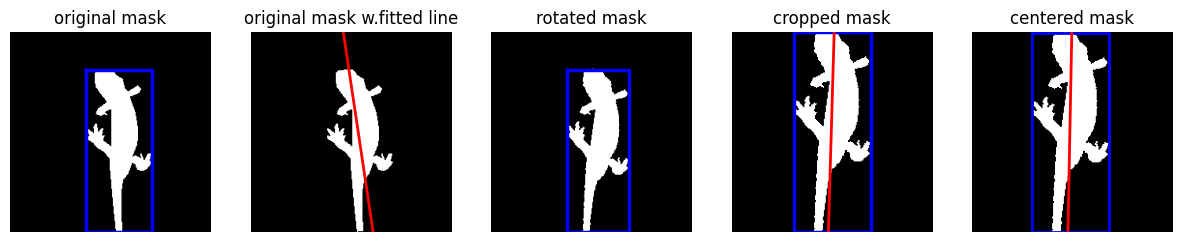

<Figure size 640x480 with 0 Axes>

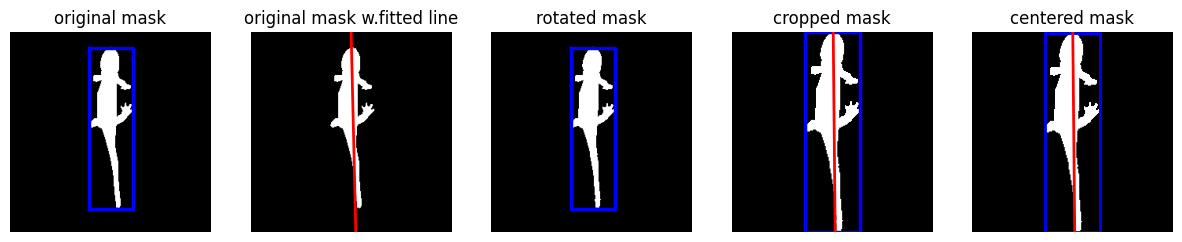

In [ ]:
#run transformations on samples : rotate and scale and translation

for sample in msk_samples:

  #resize to 256,256
  to_resize = Image.fromarray((sample * 255).astype(np.uint8))
  sample= np.array(non_stretching_resize(to_resize,"L"))

  # rotate image
  start,end=fitted_line(sample,False)
  rotated_img=apply_rotate_img(sample)

  # zoom in and crop
  newminr, newminc, newmaxc,newmaxr=zoom_bounds(rotated_img,rotated_img,False)
  cropped_img=rotated_img[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]

  # translate
  img_shifted = center_mask(cropped_img)

  fig=plt.figure(figsize=(15,10))
  plt.subplot(1,5,1)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(sample)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(sample,cmap="gray")
  plt.title('original mask')
  plt.axis("off")

  plt.subplot(1,5,2)
  plt.imshow(sample,cmap="gray")
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.title("original mask w.fitted line")
  plt.axis("off")

  plt.subplot(1,5,3)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(rotated_img)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(rotated_img,cmap="gray")
  plt.title("rotated mask")
  plt.axis("off")

  plt.subplot(1,5,4)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(cropped_img)
  start,end=fitted_line(cropped_img,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(cropped_img,cmap="gray")
  plt.title("cropped mask")
  plt.axis("off")


  plt.subplot(1,5,5)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(img_shifted)
  start,end=fitted_line(img_shifted,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(img_shifted,cmap="gray")
  plt.title("centered mask")
  plt.axis("off")

  plt.show()
  plt.tight_layout()


In [ ]:
#run transformations on samples of mask and segment : rotate and scale and translation

for sample,segm in zip(msk_samples, sgmnt_samples):


  #resize to 256,256
  to_resize = Image.fromarray((sample * 255).astype(np.uint8))
  sample= np.array(non_stretching_resize(to_resize,"L"))
  to_resize2 = Image.fromarray((segm * 1).astype(np.uint8))
  segm= np.array(non_stretching_resize(to_resize2,"RGB"))

  # rotate image
  start,end=fitted_line(sample,False)
  rotated_img=apply_rotate_img(sample)
  rotated_sgm=replicate_rotate(segm,sample)

  # zoom in and crop
  newminr, newminc, newmaxc,newmaxr=zoom_bounds(rotated_img,rotated_img,False)
  cropped_img=rotated_img[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]
  cropped_sgm=rotated_sgm[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]

  # translate
  img_shifted = center_mask(cropped_img)
  sgm_shifted = replicate_centering(cropped_sgm,cropped_img)

  fig=plt.figure(figsize=(20,20))
  plt.subplot(1,5,1)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(sample)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(sample,cmap="gray")
  plt.title('original mask')
  plt.axis("off")

  plt.subplot(1,5,2)
  plt.imshow(sample,cmap="gray")
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.title("original mask w.fitted line")
  plt.axis("off")

  plt.subplot(1,5,3)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(rotated_img)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(rotated_img,cmap="gray")
  plt.title("rotated mask")
  plt.axis("off")

  plt.subplot(1,5,4)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(cropped_img)
  start,end=fitted_line(cropped_img,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(cropped_img,cmap="gray")
  plt.title("cropped mask")
  plt.axis("off")


  plt.subplot(1,5,5)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(img_shifted)
  start,end=fitted_line(img_shifted,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(img_shifted,cmap="gray")
  plt.title("centered mask")
  plt.axis("off")
  plt.show()
  plt.show()
  plt.tight_layout()

  fig=plt.figure(figsize=(25,20))
  plt.subplot(1,5,1)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(sample)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(segm)
  plt.title('original segmnt')
  plt.axis("off")

  plt.subplot(1,5,2)
  plt.imshow(segm)
  start,end=fitted_line(sample,False)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.title("original segmnt w.fitted line")
  plt.axis("off")

  plt.subplot(1,5,3)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(rotated_img)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.imshow(rotated_sgm)
  plt.title("rotated segmnt")
  plt.axis("off")

  plt.subplot(1,5,4)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(cropped_img)
  start,end=fitted_line(cropped_img,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2.5)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(cropped_sgm,cmap="gray")
  plt.title("cropped segmnt")
  plt.axis("off")


  plt.subplot(1,5,5)
  newminr,newminc,newmaxc,newmaxr=cropping_bounds(img_shifted)
  start,end=fitted_line(img_shifted,False)

  bx = (newminc, newmaxc, newmaxc, newminc, newminc)
  by = (newminr, newminr, newmaxr, newmaxr, newminr)
  plt.plot(bx, by, '-b', linewidth=2)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.imshow(sgm_shifted,cmap="gray")
  plt.title("centered segmnt")
  plt.axis("off")
  plt.show()
  plt.show()
  plt.tight_layout()


In [ ]:
#run transformations on segments : rotate and scale and translation

for sample,segm in zip(msk_samples, sgmnt_samples):


  #resize to 256,256
  to_resize = Image.fromarray((sample * 255).astype(np.uint8))
  sample= np.array(non_stretching_resize(to_resize,"L"))
  to_resize2 = Image.fromarray((segm * 1).astype(np.uint8))
  segm= np.array(non_stretching_resize(to_resize2,"RGB"))

  # rotate image
  start,end=fitted_line(sample,False)
  rotated_img=apply_rotate_img(sample)
  rotated_sgm=replicate_rotate(segm,sample)

  # zoom in and crop
  newminr, newminc, newmaxc,newmaxr=zoom_bounds(rotated_img,rotated_img,False)
  cropped_img=rotated_img[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]
  cropped_sgm=rotated_sgm[int(newminr):int(newmaxr),int(newminc):int(newmaxc)]

  # translate
  img_shifted = center_mask(cropped_img)
  sgm_shifted = replicate_centering(cropped_sgm,cropped_img)


  fig=plt.figure(figsize=(25,20))
  plt.subplot(1,5,1)
  plt.imshow(segm)
  plt.title('original segmnt')
  plt.axis("off")

  plt.subplot(1,5,2)
  plt.imshow(segm)
  start,end=fitted_line(sample,False)
  plt.plot(list(start),list(end),color="red",linewidth=2)
  plt.title("original segmnt w.fitted line")
  plt.axis("off")

  plt.subplot(1,5,3)
  plt.imshow(rotated_sgm)
  plt.title("rotated segmnt")
  plt.axis("off")

  plt.subplot(1,5,4)
  plt.imshow(cropped_sgm,cmap="gray")
  plt.title("cropped segmnt")
  plt.axis("off")


  plt.subplot(1,5,5)

  plt.imshow(sgm_shifted,cmap="gray")
  plt.title("centered segmnt")
  plt.axis("off")
  plt.show()
  plt.show()
  plt.tight_layout()


In [ ]:
# plot openCV contour options on mask samples

for  mask in msk_samples[:10]:
  mask=run_affine_transform(mask)
    # Find contours
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Compute convex hull of largest contour
  largest_contour = max(contours, key=cv2.contourArea)
  hull = cv2.convexHull(largest_contour, returnPoints=False)
  defects = cv2.convexityDefects(largest_contour, hull)
  #print(hull.shape)

  # plot subplots
  fig, axs = plt.subplots(ncols=4, figsize=(10, 5))

  # plot mask
  axs[0].imshow(mask, cmap='gray')
  axs[0].set_title("Mask")

  # plot defects
  axs[1].imshow(mask, cmap='gray')
  axs[1].set_title("Convexity Defects")
  for i in range(defects.shape[0]):
      s, e, f, d = defects[i, 0]
      start = tuple(largest_contour[s][0])
      end = tuple(largest_contour[e][0])
      far = tuple(largest_contour[f][0])
      axs[1].plot([start[0], end[0]], [start[1], end[1]], color='green', linewidth=2)
      axs[1].plot(far[0], far[1], 'ro')
  # plot convex hull
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Compute convex hull of largest contour
  largest_contour = max(contours, key=cv2.contourArea)
  hull = cv2.convexHull(largest_contour)

  axs[2].imshow(mask, cmap='gray')
  axs[2].set_title("Convex Hull")
  axs[2].plot(largest_contour[:, 0, 0], largest_contour[:, 0, 1], '-r', linewidth=2.5)
  axs[2].plot(hull[:,0,0], hull[:,0,1], '-b', linewidth=2.5)

  # Compute Poly approx
  cnt=np.concatenate(contours)
  perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour with a polygonal curve
  approx_curve = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    # Centroid
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
  approx_curve = np.append(approx_curve, [approx_curve[0]], axis=0)

  # Extract the x and y coordinates of the approximated curve
  x = approx_curve[:, 0, 0]
  y = approx_curve[:, 0, 1]
  head_point=min(approx_curve,key=lambda x: x[0][1])
  tail_point=max(approx_curve,key=lambda x: x[0][1])

  # Plot the original image and the approximated curve
  axs[3].imshow(img)
  axs[3].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
  axs[3].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
  axs[3].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")

  axs[3].plot(x, y, '-r', linewidth=2,zorder=2)
  axs[3].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
  axs[3].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
 # Compute and print the angle between upper and lower body lines
  upper_body_vec = np.array([head_point[0][0] - cx, head_point[0][1] - cy])
  lower_body_vec = np.array([tail_point[0][0] - cx, tail_point[0][1] - cy])
  angle = np.degrees(np.arctan2(np.linalg.det([upper_body_vec, lower_body_vec]), np.dot(upper_body_vec, lower_body_vec)))
  print("Angle between upper and lower body lines: {:.2f} degrees".format(abs(angle)))

  #axs[3].legend()
  axs[3].set_title("Approximated Curve")

  plt.show()


In [ ]:
# plot approx polygone for a given salam mask

# Load the mask
msk =run_affine_transform(msk_samples[5])

# Find contours
contours, _ = cv2.findContours(msk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt=np.concatenate(contours)
# Loop through the contours and detect curves
if True :
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour with a polygonal curve
    approx_curve = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    print("shape approx_curve {}".format(approx_curve.shape))
    # Centroid
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    # Check if the number of vertices in the approximated curve is less than the number of vertices in the contour
    # Draw the contour on a copy of the original image
    img = cv2.cvtColor(msk, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
    approx_curve = np.append(approx_curve, [approx_curve[0]], axis=0)

        # Extract the x and y coordinates of the approximated curve
    x = approx_curve[:, 0, 0]
    y = approx_curve[:, 0, 1]
    head_point=min(approx_curve,key=lambda x: x[0][1])
    tail_point=max(approx_curve,key=lambda x: x[0][1])

        # Plot the original image and the approximated curve
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
    ax.scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
    ax.scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")

    ax.plot(x, y, '-r', linewidth=2,zorder=2)
    ax.plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
    ax.plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
 # Compute and print the angle between upper and lower body lines
    upper_body_vec = np.array([head_point[0][0] - cx, head_point[0][1] - cy])
    lower_body_vec = np.array([tail_point[0][0] - cx, tail_point[0][1] - cy])
    angle = np.degrees(np.arctan2(np.linalg.det([upper_body_vec, lower_body_vec]), np.dot(upper_body_vec, lower_body_vec)))
    print("Angle between upper and lower body lines: {:.2f} degrees".format(abs(angle)))

    ax.legend()
    ax.set_title(" Image' Approximated Curve")
    plt.show()

i+=1


In [ ]:
# plot approx polygone for smg samples
i=0
cpt=0

for  mask,sgm in zip(msk_samples[:],sgmnt_samples[:]):
  i+=1
  mask,sgm=run_affine_transform(mask,sgm,True)

  # plot subplots
  fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Compute Poly approx
  cnt=np.concatenate(contours)
  perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour with a polygonal curve
  approx_curve = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    # Centroid
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
  approx_curve = np.append(approx_curve, [approx_curve[0]], axis=0)

  # Extract the x and y coordinates of the approximated curve
  x = approx_curve[:, 0, 0]
  y = approx_curve[:, 0, 1]
  head_point=min(approx_curve,key=lambda x: x[0][1])
  tail_point=max(approx_curve,key=lambda x: x[0][1])

  # Plot the original image and the approximated curve
  axs[0].imshow(img)
  axs[0].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
  axs[0].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
  axs[0].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")

  axs[0].plot(x, y, '-r', linewidth=2,zorder=2)
  axs[0].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
  axs[0].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
 # Compute and print the angle between upper and lower body lines
  upper_body_vec = np.array([head_point[0][0] - cx, head_point[0][1] - cy])
  lower_body_vec = np.array([tail_point[0][0] - cx, tail_point[0][1] - cy])
  angle = np.degrees(np.arctan2(np.linalg.det([upper_body_vec, lower_body_vec]), np.dot(upper_body_vec, lower_body_vec)))
  print("Angle between upper and lower body lines: {:.2f} degrees".format(abs(angle)))
  print(" sample n:{} ".format(i))
  #axs[3].legend()
  axs[0].set_title("Approximated msk Curve")
  axs[0].axis("off")

  axs[1].imshow(sgm)
  axs[1].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
  axs[1].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
  axs[1].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
  axs[1].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
  axs[1].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")
  axs[1].set_title("Approximated img Curve")
  axs[1].axis("off")


  axs[2].imshow(sgm)
  if abs(angle)>165:
    axs[2].axis("off")
    axs[2].set_title("straight salamander",color="green")

  else:
    axs[2].axis("off")
    axs[2].set_title("curved salamander",color="red")
    cpt+=1

  plt.show()
print("totale of {} curved salamanders in batch of {} ".format(cpt,i-1))

# Curved salamander alignment

In [ ]:
# plot curve detection for specific mask,segment couple
i=0
cpt=0
for  mask,sgm in zip(msk_samples[48:49],sgmnt_samples[48:49]):
  i+=1
  mask,sgm=run_affine_transform(mask,sgm,True)

  # plot subplots
  fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Compute Poly approx
  cnt=np.concatenate(contours)
  perimeter = cv2.arcLength(cnt, True)

    # Approximate the contour with a polygonal curve
  approx_curve = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    # Centroid
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])
  img=mask
  img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(img, [cnt], -1, (0, 0, 255), 2)
  approx_curve = np.append(approx_curve, [approx_curve[0]], axis=0)

  # Extract the x and y coordinates of the approximated curve
  x = approx_curve[:, 0, 0]
  y = approx_curve[:, 0, 1]
  head_point=min(approx_curve,key=lambda x: x[0][1])
  tail_point=max(approx_curve,key=lambda x: x[0][1])

  # Plot the original image and the approximated curve
  axs[0].imshow(img)
  axs[0].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
  axs[0].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
  axs[0].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")

  axs[0].plot(x, y, '-r', linewidth=2,zorder=2)
  axs[0].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
  axs[0].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
  curved,angle=curved_salam(mask,True)

  print(" sample n:{} ".format(i))
  #axs[3].legend()
  axs[0].set_title("Approximated msk Curve")
  axs[0].axis("off")

  axs[1].imshow(sgm)
  axs[1].plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
  axs[1].plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
  axs[1].scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
  axs[1].scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
  axs[1].scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")
  axs[1].set_title("Approximated img Curve")
  axs[1].axis("off")
  axs[1].axvline(x=sgm.shape[1] // 2, color='red', linestyle='--')
  print("{} : Angle between upper and lower body lines: {:.2f} degrees".format(curved,angle))
  axs[2].imshow(sgm)
  if curved:
    axs[2].axis("off")
    axs[2].set_title("curved salamander",color="red")
  else:
    axs[2].axis("off")
    axs[2].set_title("straight salamander",color="green")

  plt.show()


In [ ]:
msk_samples,img_samples,sgmnt_samples=load_batch(12)

In [ ]:
i=0
cpt=0
for  mask,sgmnt in zip(msk_samples[:],sgmnt_samples[:]):
  i+=1
  salam_msk,salam_sgm=run_affine_transform(mask,sgmnt,True)
  curved,curve_angle=curved_salam(salam_msk,True)
  if curved:
    cpt+=1
    print("sample {} ".format(i-1))
    head_point,centroid,tail_point= approx_polygone_points(salam_msk)
    x1, y1 = head_point[0][0], head_point[0][1]
    x2, y2 = cx, cy= centroid
    angle = np.arctan2(x2 - x1, y2 - y1) * 180 / np.pi

    plt.figure(figsize=(20,15))
    plt.subplot(1,5,1)
    plt.imshow(salam_sgm)
    plt.axis("off")

    plt.subplot(1,5,2)
    plt.imshow(salam_sgm)
    plt.plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
    plt.plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
    plt.scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
    plt.scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
    plt.scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")
    plt.axis("off")
    plt.axvline(x=salam_sgm.shape[1] // 2, color='red', linestyle='--')
    plt.axhline(y=cy,color="pink",linestyle="--")

    sgm,msk=unwrap_curve(salam_msk,salam_sgm,True,smooth=5)
    head_point,centroid,tail_point= approx_polygone_points(msk)
    cx, cy= centroid

    plt.subplot(1,5,3)
    plt.imshow(sgm)
    plt.axis("off")

    plt.subplot(1,5,4)
    plt.imshow(msk,cmap="gray")
    plt.axis("off")
    _,curve_angle2=curved_salam(msk,True)
    print("old angle {:.2f} ; new angle {:.2f}".format(abs(curve_angle),abs(curve_angle2)))

    plt.subplot(1,5,5)
    plt.imshow(sgm)
    plt.plot([head_point[0][0],cx],[head_point[0][1],cy],color="orange",linewidth=2)#upper body line
    plt.plot([tail_point[0][0],cx],[tail_point[0][1],cy],color="green",linewidth=2) #lower body line
    plt.scatter(head_point[0][0],head_point[0][1],color="orange",linewidth=2.5,zorder=3,label="head point")
    plt.scatter(tail_point[0][0],tail_point[0][1],color="green",linewidth=2.5,zorder=3,label="tail point")
    plt.scatter(cx,cy,color="pink",linewidth=2.5,zorder=3,label="centroid point")
    plt.axis("off")

    plt.show()

print("totale of {} curved salamanders in batch of {} ".format(cpt,i-1))

# K-Means

In [ ]:

def opening_op(msk,iter=1):

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_open = cv2.morphologyEx(msk, cv2.MORPH_OPEN, kernel, iterations=iter)

    return img_open

def RGB_2_HSV(img):
    print(type(img))
    hsv=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    return hsv

def BGR_2_GRAY(img):
    if img.ndim == 2:
        return img
    img = np.float32(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def RGB_2_LAB(img):
    # Convert RGB to LAB
    img = np.float32(img)  # Convert image to float32 format
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to CIELAB* color space
    return lab

def BGR_2_LAB(img):

    img=np.float32(img)
    lab=cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    return lab

def LAB_RGB(img):

    img=np.float32(img)
    rgb=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    return rgb


In [ ]:
def plot_kmeans_trioseg(orig,image,spot_seg):

    fig = plt.figure(figsize=(15, 11))

    plt.subplot(1, 3, 1)
    plt.title("rgb segmented image ")
    plt.imshow(orig.astype('uint8'))

    plt.subplot(1, 3, 2)
    plt.title("lab segmented image ")
    plt.imshow(image , cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("segmented spots")
    plt.imshow(spot_seg, cmap="gray")
    plt.show()

def plot_kmeans_seg(image,spot_seg):
    image = cv2.medianBlur(image, 5)

    fig = plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.title("segmented image ")
    plt.imshow(image.astype('uint8'))

    plt.subplot(1, 2, 2)
    plt.title("segmented spots")
    plt.imshow(spot_seg.astype('uint8'), cmap="gray")
    plt.show()

In [ ]:

def get_kmeans_data(batch=0):
  rgbs=[]

  msk_samples,_,sgmnt_samples=load_batch(batch)

  for  mask,sgmnt in zip(msk_samples[:],sgmnt_samples[:]):
    msk,sgm=run_affine_transform(mask,sgmnt,True)
    curved,curve_angle=curved_salam(msk,True)

    if curved:
      sgm,msk=unwrap_curve(msk,sgm,True,smooth=5)

    rgbs.append(sgm)
  return rgbs

In [ ]:

def Kmeans(image,lab=False,eval=False):
    y=255
    if lab :
      image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
      y=128

    image = cv2.medianBlur(image, 5)
    reshaped = image.reshape(image.shape[0] * image.shape[1], image.shape[2])
    kmeans = KMeans(n_clusters=3, n_init=10, max_iter=10).fit(reshaped)
    clustering = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (image.shape[0], image.shape[1]))
    sorted_labels = sorted([n for n in range(2)], key=lambda x: -np.sum(clustering == x))

  # Determine which cluster corresponds to yellow spots
    cluster_centers = kmeans.cluster_centers_.astype(np.uint8)
    yellow_spots_index = np.argmin(np.sum(np.abs(cluster_centers - [255, y, 0]), axis=1))

    # Create binary mask where yellow spots are white and everything else is black
    binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    binary_mask[clustering == yellow_spots_index] = 255

    if eval:
      sse = kmeans.inertia_
      silhouette=0
      silhouette = silhouette_score(reshaped, clustering.ravel())
      return binary_mask, sse, silhouette
    else:
      return binary_mask

def Kmeans_post_processing(kmeans_img):

    kmeans_img=BGR_2_GRAY(kmeans_img)
    kmeans_img=opening_op(kmeans_img)

    return kmeans_img

def run_Kmeans(lab=False,eval=False,batch=0):

    sse_scores=[]
    silhouette_scores=[]
    sgmnt=get_kmeans_data()
    print(len(sgmnt))
    for salamander in sgmnt:
      if eval:
        salamander_spots, sse, silhouette = Kmeans(salamander,lab,eval)
        sse_scores.append(sse)
        silhouette_scores.append(silhouette)
      else:
        salamander_spots=Kmeans(salamander,lab,eval)
      salamander_spots=Kmeans_post_processing(salamander_spots)
      #plot_kmeans_seg(salamander,salamander_spots)
    print("Batch {} SSE: {}".format(batch,sum(sse_scores)/len(sgmnt)))
    print("Batch {} Silhouette: {}".format(batch,sum(silhouette_scores)/len(sgmnt)))
    return silhouette_score




In [ ]:
###Evaluate K-means on dataset
batch_results={}
for batch in range(math.ceil(len(masks)/50)):
  batch_results[batch]=run_Kmeans(True,True,batch)

In [ ]:
avg_score=0
for scores in batch_results.values():
  avg_score+= sum(score)

avg_scores=avg_scores/len(masks)

In [ ]:
print(avg_scores)
#run_Kmeans(lab=True,eval=True,batch=1)